In [1]:
!pip install langchain langchain_community langchain_openai langgraph
!pip install openai
!pip install pypdf
!pip install tiktoken
!pip install -qU langchain-mongodb pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
    

In [6]:
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document


In [2]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

Enter API key for OpenAI: ··········


In [7]:
from langchain_mongodb import MongoDBAtlasVectorSearch
from pymongo import MongoClient

embeddings = OpenAIEmbeddings(model="text-embedding-3-large", dimensions=1536)

MONGODB_ATLAS_CLUSTER_URI = 'MONGO_DB_CLUSTER_URI'

# initialize MongoDB python client
client = MongoClient(MONGODB_ATLAS_CLUSTER_URI)

DB_NAME = "nhs_health_conditions_A_Z"
COLLECTION_NAME = "health_conditions"
ATLAS_VECTOR_SEARCH_INDEX_NAME = "health_conditions_index"

MONGODB_COLLECTION = client[DB_NAME][COLLECTION_NAME]

# mongo db stores that has all the scrapped data in vector representations
vector_store = MongoDBAtlasVectorSearch(
    collection=MONGODB_COLLECTION,
    embedding=embeddings,
    index_name=ATLAS_VECTOR_SEARCH_INDEX_NAME,
    relevance_score_fn="cosine",
)

# Create vector search index on the collection
vector_store.create_vector_search_index(dimensions=1536)


In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [10]:
from langchain_core.documents import Document
from langchain_core.tools import tool
from langgraph.graph import  MessagesState, StateGraph, START
from typing import List
from typing_extensions import  TypedDict
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

In [11]:
# Create a tool that retrieves relavant documents given a query
# this tool is used by the llm
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=5)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])

    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

history = {"messages": []}

# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an health care assistant chatbot for advising on treatments and self care. "
        "Use the following pieces of retrieved context to explain "
        "what the user condition may relate to. The reterived content is from the NHS A-Z website."
        "Keep your reponses consice and use simple language. "
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages


    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [12]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END : END, "tools": "tools"}
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

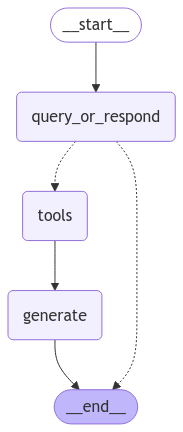

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
input_message = "I am feeling backpain. What could be the cause?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

I am feeling backpain. What could be the cause?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_U1RBlea2tUuNRi3yozMPI6kT)
 Call ID: call_U1RBlea2tUuNRi3yozMPI6kT
  Args:
    query: backpain causes
================================= Tool Message =================================
Name: retrieve

Source: {'_id': '6779bc800a09cab81acba9cc', 'source': 'https://www.nhs.uk/conditions/back-pain/', 'title': 'Back pain - NHS', 'start_index': 0}
Content: Back pain, particularly lower back pain, is very common. It usually improves within a few weeks but can sometimes last longer or keep coming back. There are things you can do to help ease the pain.Causes of back painBack pain can have many causes. It's not always obvious what causes it, and it often gets better on its own.A common cause of back pain is an injury like a pulled muscle (strain).Sometimes, med